In [1]:
# install certain module
!pip3 install box2d-py
!pip3 install gym[Box_2D]
import gym
env = gym.make("LunarLander-v2")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 448 kB 12.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
# Create DQN algorithm and run it

from cmath import sin
import random
import collections
import math
# from tkinter import W
import gym
import numpy as np
import Box2D
import torch
import os
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import copy


import matplotlib.pyplot as plt
#%%
# reward for each training episode while training my agent
torch.manual_seed(0)
np.random.seed(0)
torch.use_deterministic_algorithms(True)
torch.backends.deterministic = True
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything()

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)



#%%
class LunarLanderAgent(object):
    def __init__(self):
        self.env = gym.make('LunarLander-v2')
        self.nn_best = NeuralNetwork()
        self.nn = NeuralNetwork()
        self.gamma =0.99
        self.memory = collections.deque(maxlen=5000000)
        # self.n = 0.01
        self.rewards = []
        self.success = {"bool": False, "episode": -1, "reward": -1}
        self.steps = 0
        self.history_length = 4
        self.final_eps=0.01
        self.no_op_max = 30

        self.nn_best = copy.deepcopy(self.nn)


    def get_action(self, state, e):

        if np.random.random() < e:
            action = self.env.action_space.sample()
        else:
            with torch.no_grad():
                action = (np.argmax(self.nn(torch.from_numpy(np.array(state).astype(np.float32))))).item()        
        return action  
                

    def nn_train(self): 
        loss_function = nn.L1Loss()
        optimizer = torch.optim.Adam(self.nn.parameters(), lr= 0.0003)
        
        inputs = []
        targets = []
        
        if len(self.memory)<64:
            return 0
        miniBatch = random.sample(self.memory,64)

        for x_t, a, r, x_t_1, done in miniBatch:
            
            y = 0
            if done:
                y += r
            else:
                y += r + self.gamma* max(self.nn_best(torch.from_numpy(np.array(x_t_1).astype(np.float32)))) # y: max Q_t+1

            y_ = self.nn(torch.from_numpy(np.array(x_t).astype(np.float32)))#  y_: Q_t
            y_[a] = y

            inputs.append(x_t)
            targets.append(y_.tolist())
        # print(inputs)
        # print(targets)
        
        dataset = myDataset(inputs, targets)
        train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)   
        for i, data in enumerate(train_dataloader, 0):
            train_features, train_labels = data

            optimizer.zero_grad()
            
            predict = self.nn(train_features)
            
            loss = loss_function(predict, train_labels)
            loss.backward()

            optimizer.step()

            
            
            
        self.nn_best = copy.deepcopy(self.nn)
            
            

    def train_agent(self, max_episode =1000000, max_step = 500):   
        
        
        for episode in range(max_episode):
            print("Episode: ", episode)
            x_t = self.env.reset()
            s = x_t
            reward=0

            for step in range(max_step):
                self.steps += 1
                
                e = max(self.final_eps, 0.994**episode)
                action = self.get_action(s, e)
                x_t_1, r, done, info = self.env.step(action)

                s_next = x_t_1
                reward += r

                self.memory.append([s, action, r, s_next, done])
                
                if episode > self.no_op_max and self.steps % self.history_length == 0:
                    
                    self.nn_train()
                    # if episode%50 == 0:
                    #     self.env.render()

                if done:
                    # self.env.close()
                    break
                s = s_next  

            self.rewards.append(reward)
            if episode%50 == 0 and episode>0:
                print("average 50:",(sum(self.rewards[-50:])/50))

            # print(reward)
            if len(self.rewards)>=100:
                R = sum(self.rewards[-100:])/100 
                if R >200:
                    self.success["bool"] = True
                    self.success["episode"] = episode
                    self.success["reward"] = R
                    print("Successfully trained agent, average score ", R, " at episode ", episode)
                    return self.nn
        return None   

class NeuralNetwork(nn.Module):

    def __init__(self):

        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(8, 80),
            nn.ReLU(),
            nn.Linear(80, 40),
            nn.ReLU(),
            nn.Linear(40, 4),
        )
        self.layers.apply(init_weights)

    def forward(self, x):
        return self.layers(x)

class myDataset(Dataset):
    def __init__(self, inputs, targets):

        self.inputs =torch.from_numpy(np.array(inputs))
        # m = self.inputs.mean(0, keepdim=True)
        # s = self.inputs.std(0, unbiased=False, keepdim=True)
        # self.inputs -= m
        # self.inputs /= s
        self.targets = torch.from_numpy(np.array(targets))

    def __len__(self):
        
        return len(self.inputs)

    def __getitem__(self, idx):
        
        return self.inputs[idx], self.targets[idx]
#  Experience Replay, Fixed Q-Targets, TAU, update target every x steps

# %% 
agent = LunarLanderAgent()
trained_agent = agent.train_agent()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Episode:  0
Episode:  1
Episode:  2
Episode:  3
Episode:  4
Episode:  5
Episode:  6
Episode:  7
Episode:  8
Episode:  9
Episode:  10
Episode:  11
Episode:  12
Episode:  13
Episode:  14
Episode:  15
Episode:  16
Episode:  17
Episode:  18
Episode:  19
Episode:  20
Episode:  21
Episode:  22
Episode:  23
Episode:  24
Episode:  25
Episode:  26
Episode:  27
Episode:  28
Episode:  29
Episode:  30
Episode:  31
Episode:  32
Episode:  33
Episode:  34
Episode:  35
Episode:  36
Episode:  37
Episode:  38
Episode:  39
Episode:  40
Episode:  41
Episode:  42
Episode:  43
Episode:  44
Episode:  45
Episode:  46
Episode:  47
Episode:  48
Episode:  49
Episode:  50
average 50: -164.69684239728457
Episode:  51
Episode:  52
Episode:  53
Episode:  54
Episode:  55
Episode:  56
Episode:  57
Episode:  58
Episode:  59
Episode:  60
Episode:  61
Episode:  62
Episode:  63
Episode:  64
Episode:  65
Episode:  66
Episode:  67
Episode:  68
Episode:  69
Episode:  70
Episode:  71
Episode:  72
Episode:  73
Episode:  74
Epi

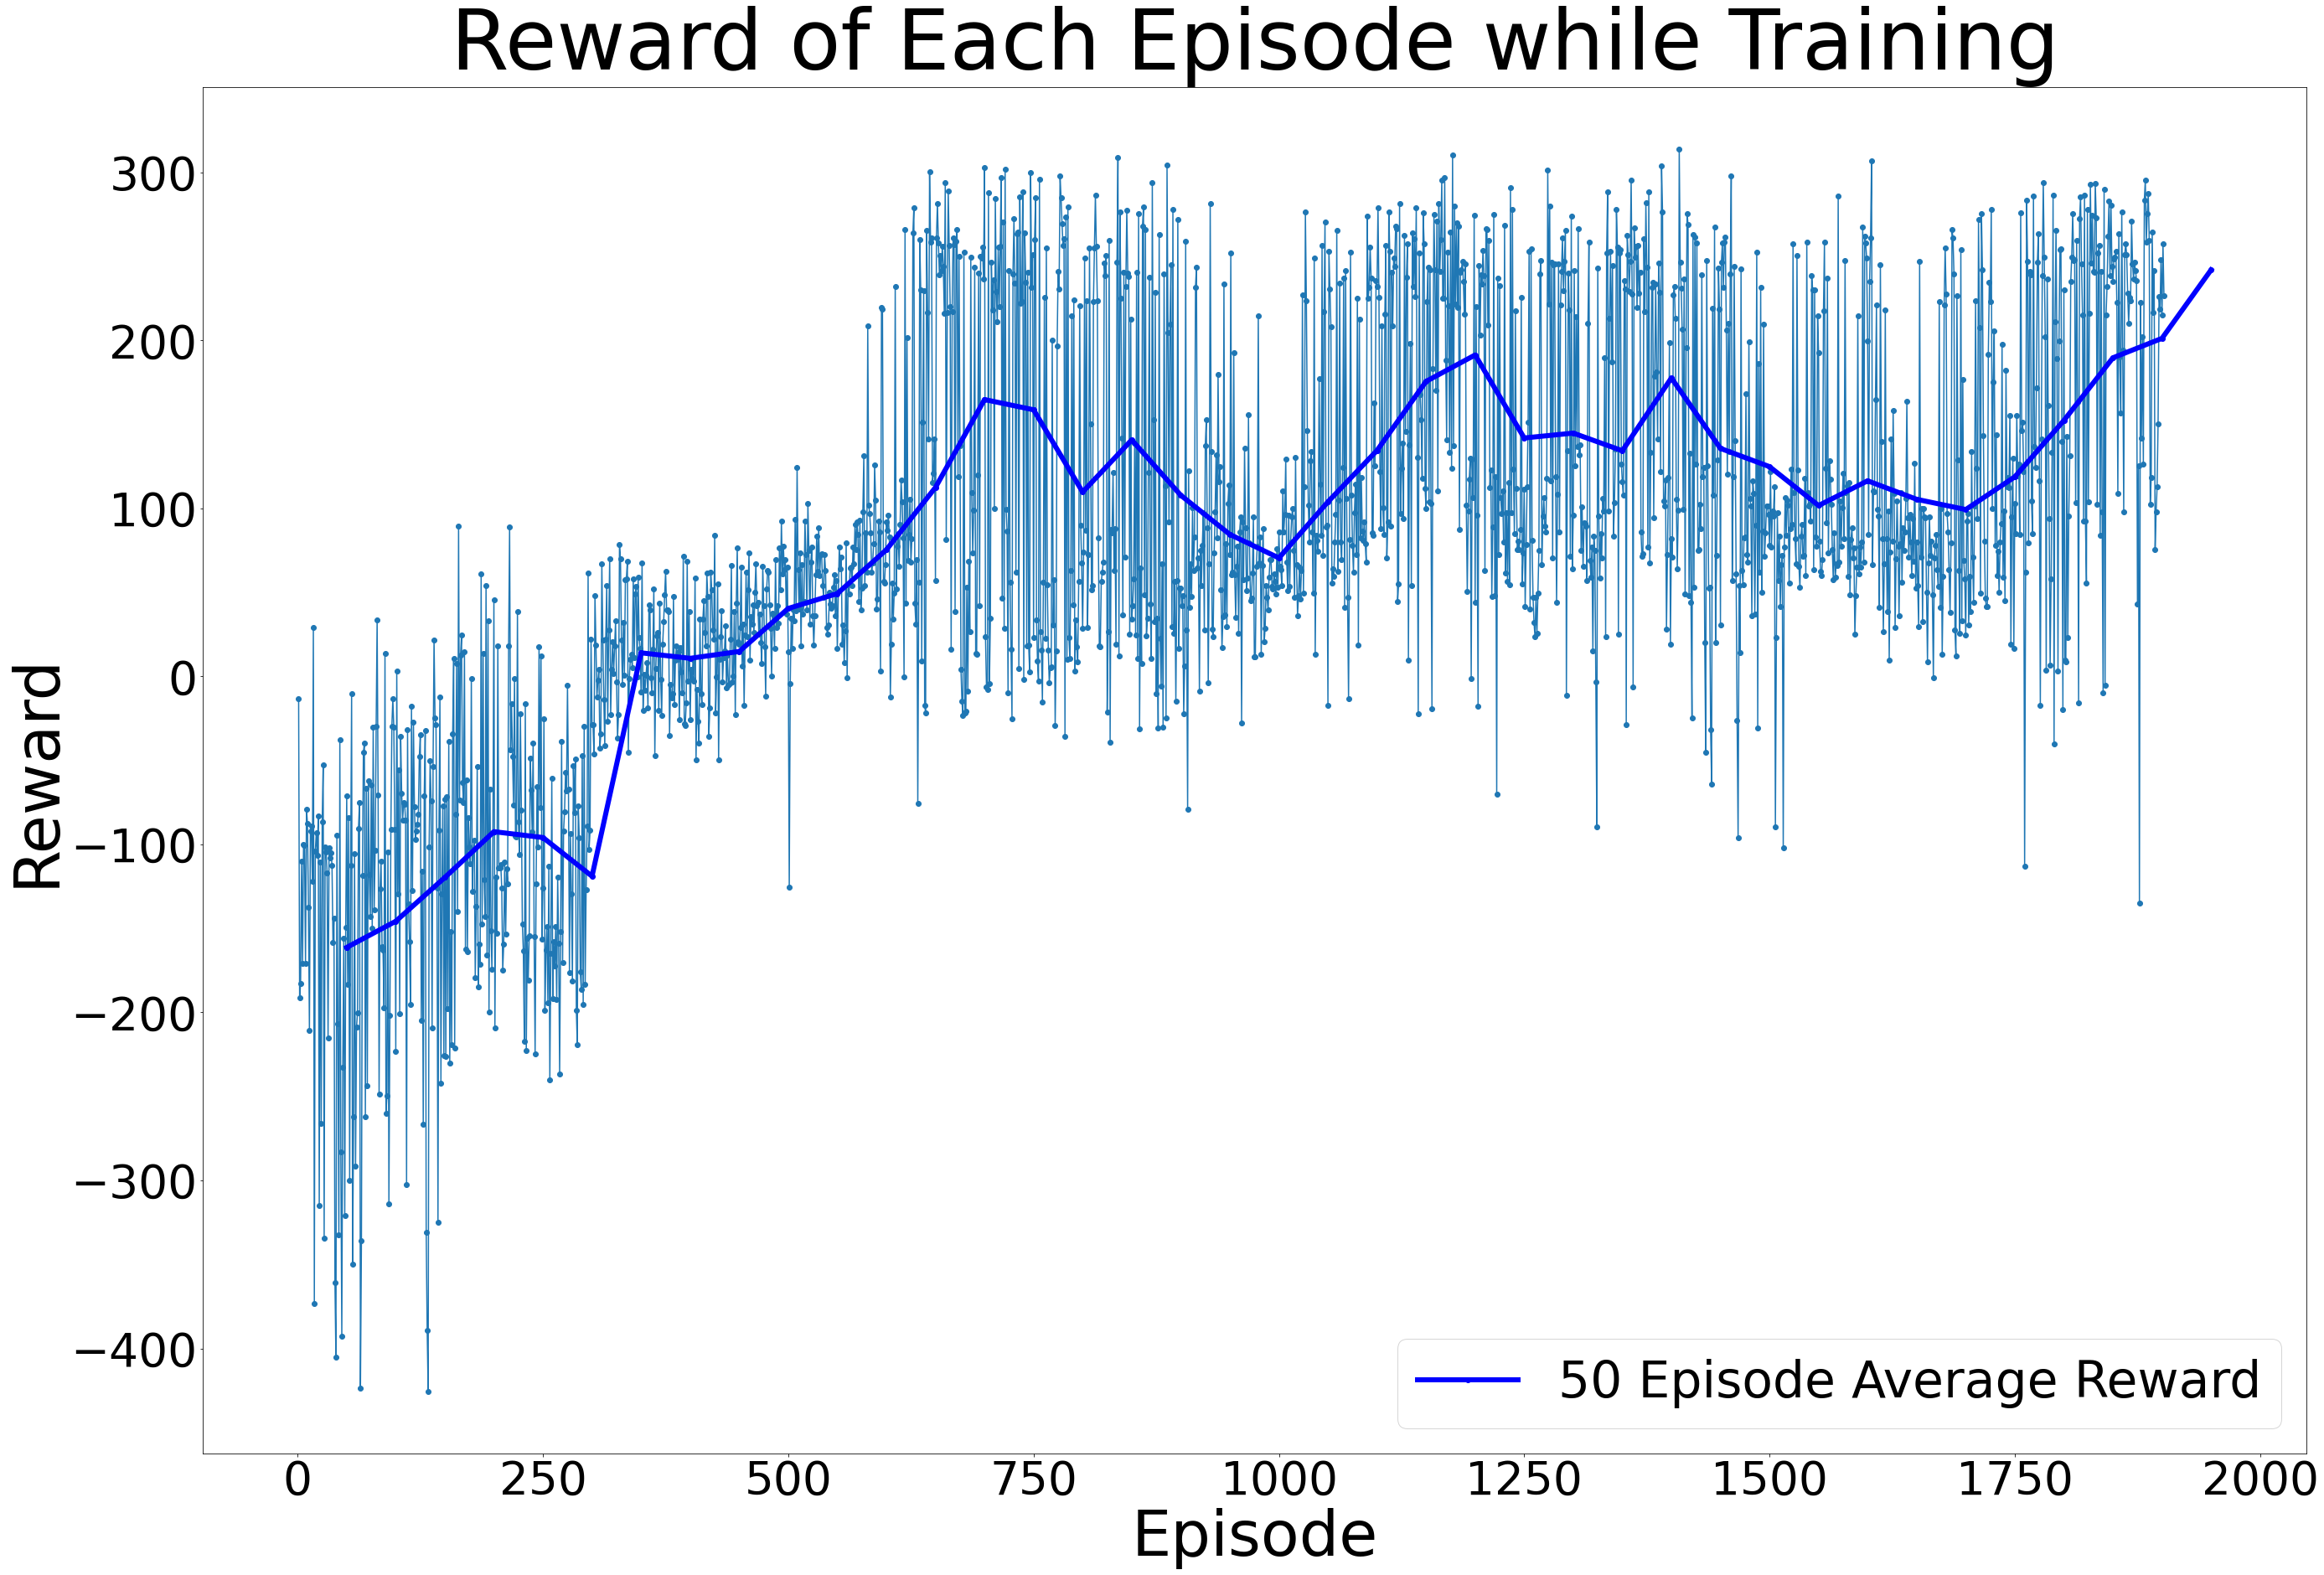

In [40]:
# Plot the reward per episode while training

plt.figure(figsize=(45,30))
plt.plot(range(1,len(agent.rewards)+1),agent.rewards,'-o')
plt.ylabel('Reward',size=75)
plt.xlabel('Episode',size=75)
plt.title('Reward of Each Episode while Training',size=100)
plt.xticks(fontsize= 55)
plt.yticks(fontsize= 55)

reward_50= []
r = 0
e = 0
for i in range(len(agent.rewards)):
  r += agent.rewards[i]
  if (i+1)%50 == 0 or i == len(agent.rewards)-1:
    e += 1
    reward_50.append(r/(i - 50*e+51))
    r = 0
plt.plot([50*a for a in range(1,1+len(reward_50))],reward_50,'-o', linewidth=6, color="blue", label = "50 Episode Average Reward")

plt.legend( prop={'size': 60})
plt.show()

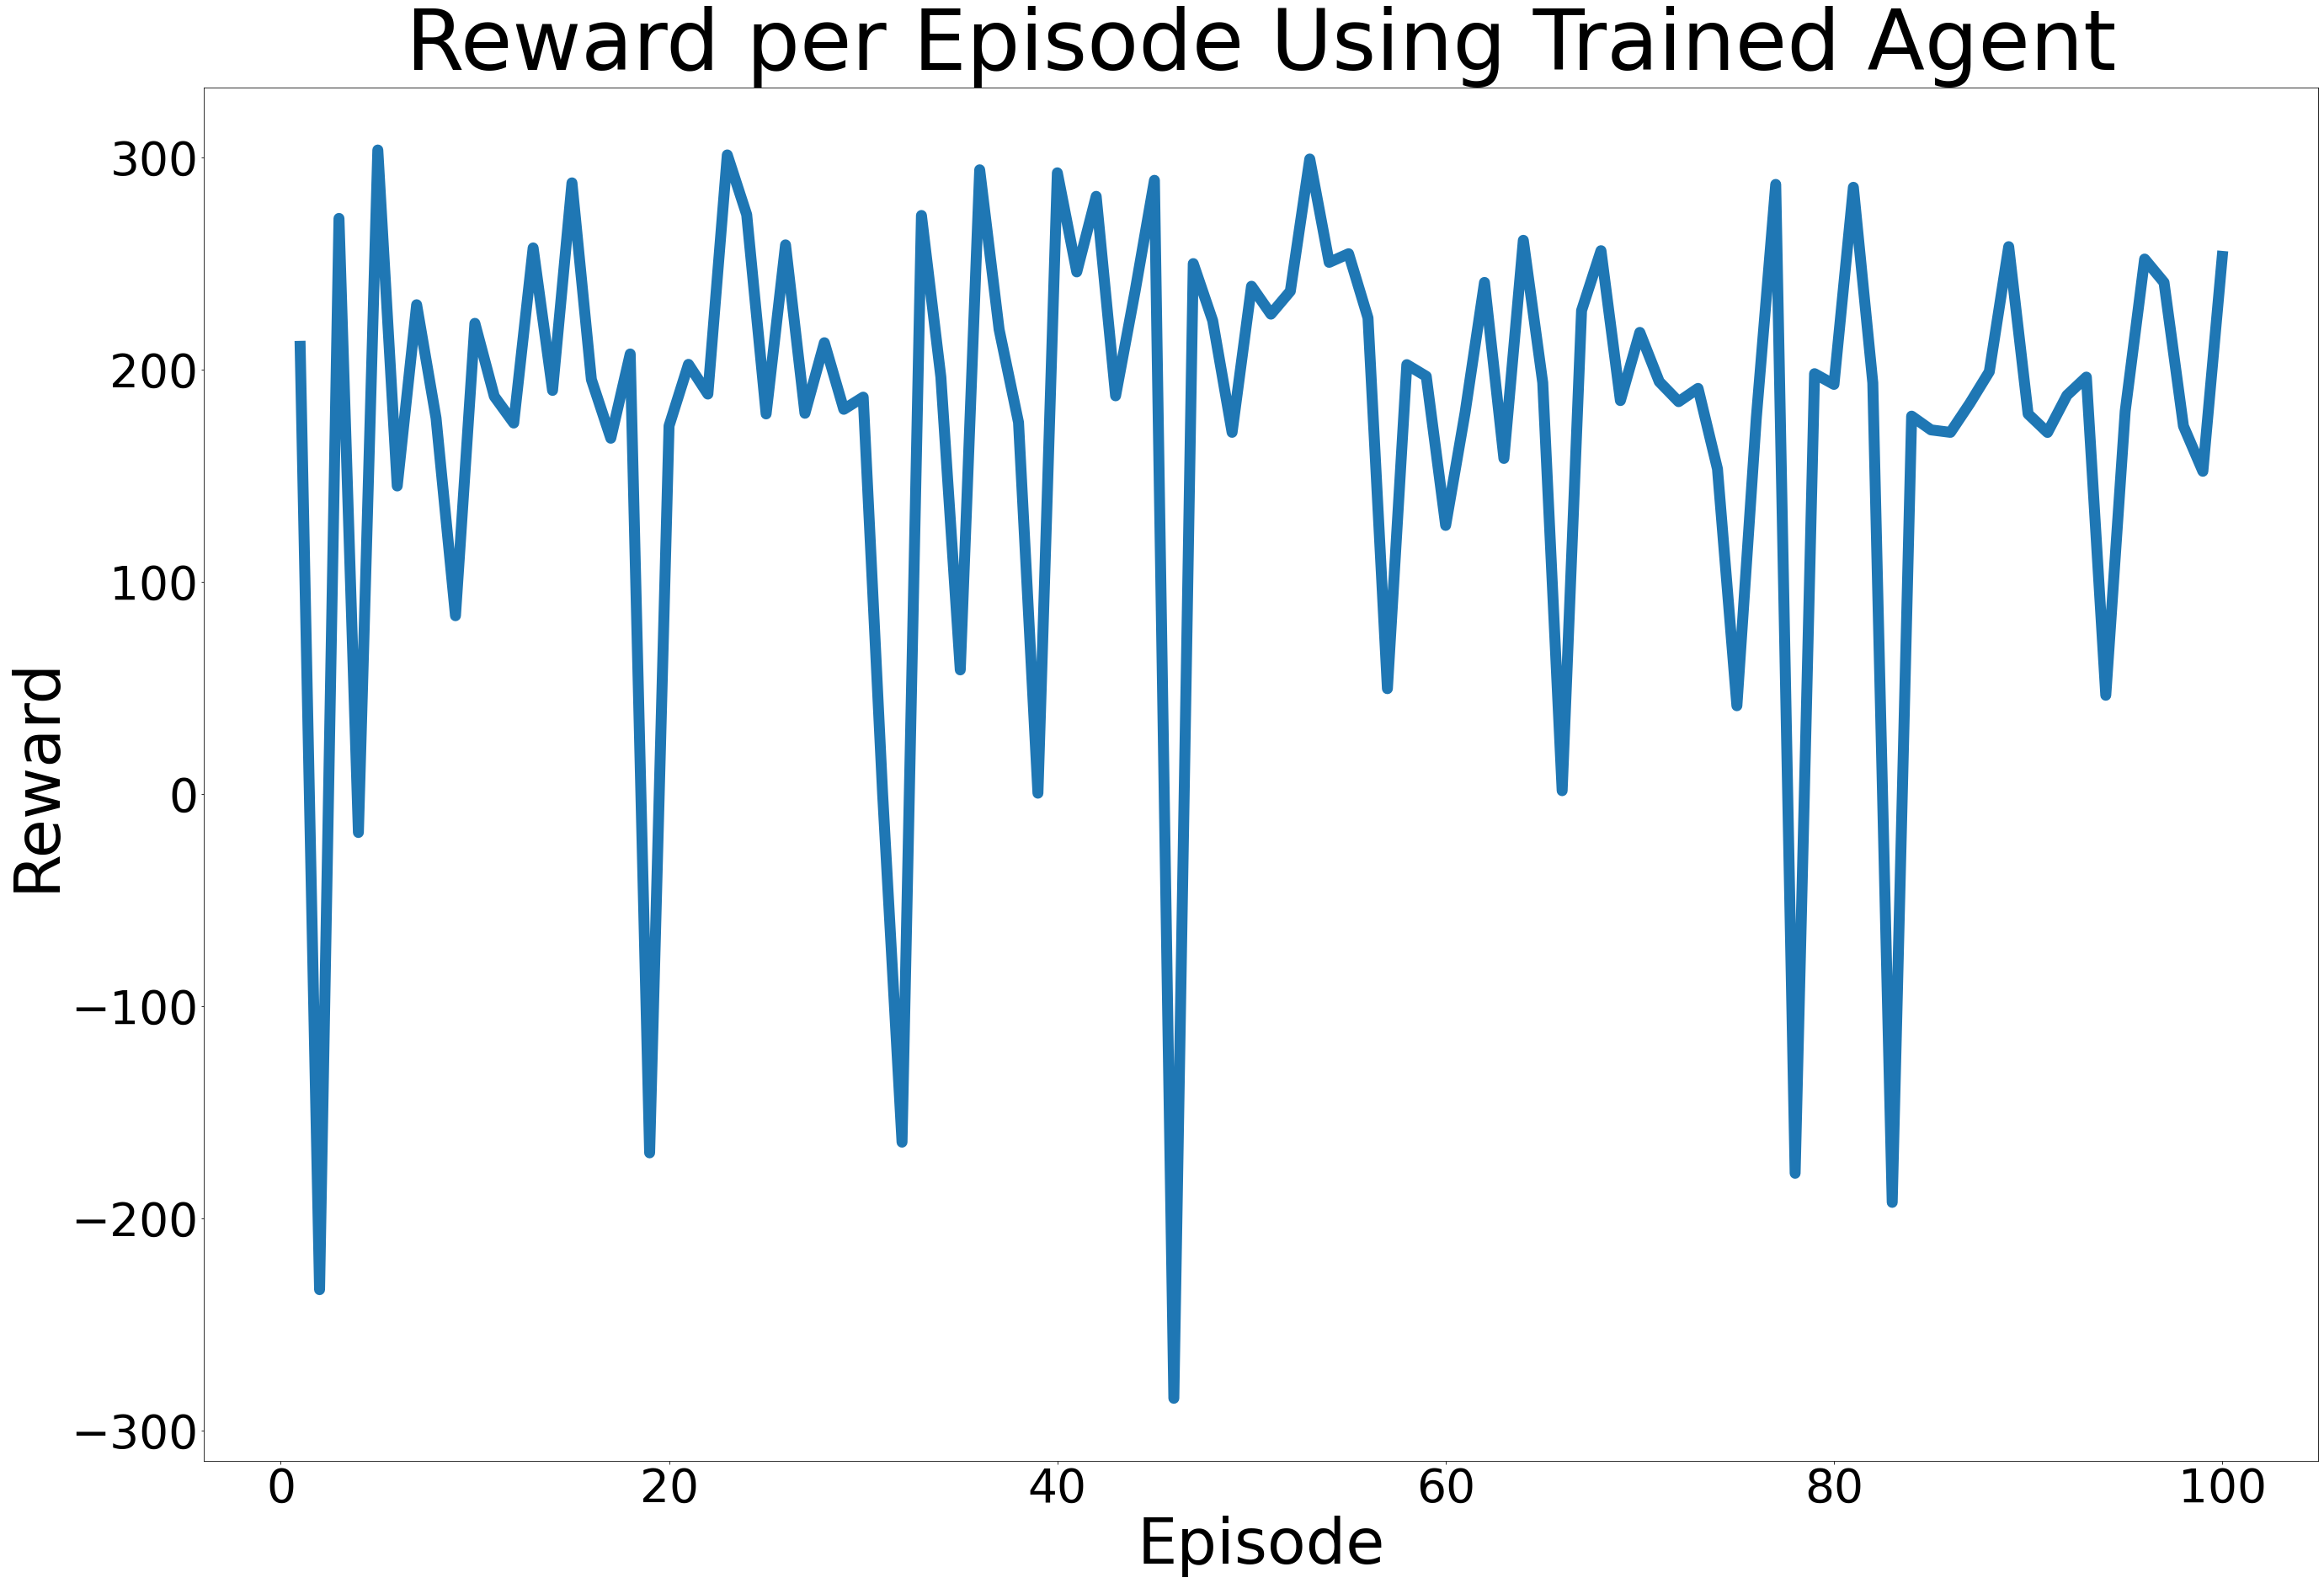

In [45]:
# Plot the reward per episode using the trained agent

env = gym.make('LunarLander-v2')
rewards = []
for episode in range(100):
    s = env.reset()
    reward=0
    for step in range(1000):
        x = agent.nn(torch.from_numpy(np.array(s).astype(np.float32)))
        action = np.argmax(x.tolist())
        s_next, r, done, info = env.step(action)
        reward += r

        if done:
            break
        s = s_next  

    rewards.append(reward)

plt.figure(figsize=(45,30))
plt.plot(range(1,len(rewards)+1),rewards,'-o',linewidth=13)
plt.ylabel('Reward',size=75)
plt.xlabel('Episode',size=75)
plt.title('Reward per Episode Using Trained Agent',size=100)
plt.xticks(fontsize= 55)
plt.yticks(fontsize= 55)


plt.show()